# Monitoring chlorophyll-*a* in Australian waterbodies <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_s2am_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_s2am_ard_3), 
[ga_s2bm_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_s2bm_ard_3)

## Background
Inland waterbodies are essential for supporting human life, both through the supply of drinking water and the support of agriculture and aquaculture.
Such waterbodies can be contaminated by outbreaks of blue-green (and other toxic) algae, causing health issues for people and animals.
For example, up to a million fish died during an [algal bloom event](https://www.abc.net.au/news/2019-01-08/second-fish-kill-in-darling-river-at-menindee/10696632) in the Darling river in late 2018 and early 2019. 
While the health of waterbodies can be monitored from the ground through sampling, satellite imagery can complement this, potentially improving the detection of large algal bloom events.
However, there needs to be a well-understood and tested way to link satellite observations to the presence of algal blooms.

### Sentinel-2 use case
Algal blooms are associated with the presence of clorophyll-*a* in waterbodies.
[Mishra and Mishra (2012)](https://doi.org/10.1016/j.rse.2011.10.016) developed the normalised difference chlorophyll index (NDCI), which serves as a qualitative indicator for the concentration of clorophyll-*a* on the surface of a waterbody.
The index requires information from a specific part of the infrared specturm, known as the 'red edge'. 
This is captured as part of Sentinel-2's 13 spectral bands, making it possible to measure the NDCI with Sentinel-2. 

## Description

In this example, we measure the NDCI for one of the Menindee Lakes, which was strongly affected by the algal bloom event mentioned in the Background section.
This is combined with information about the size of the waterbody, which is used to build a helpful visualisation of how the water-level and presence of chlorophyll-*a* changes over time.
The worked example takes users through the code required to:

1. Load cloud-free Sentinel-2 images for an area of interest.
2. Compute indices to measure the presence of water and clorophyll-*a*.
3. Generate informative visualisations to identify the presence of clorophyll-*a*.

### Some caveats

* The NDCI is currently treated as an experimental index for Australia, as futher work is needed to calibrate and validate how well the index relates to the presence of clorophyll-*a*. 
* It is also important to remember that algal blooms will usually result in increased values of the NDCI, but not all NDCI increases will be from algal blooms.
For example, there may be seasonal fluctuations in the amount of clorophyll-*a* in a waterbody.
* Further validation work is required to understand how shallow water and atmospheric effects affect the NDCI, and its use in identifying high concentrations of clorophyll-*a*.

***

## Getting started

**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app="Chlorophyll_monitoring")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
The parameters are

* `latitude`: The latitude range to analyse (e.g. `(-32.423, -32.523)`).
For reasonable loading times, make sure the range spans less than ~0.1 degrees.
* `longitude`: The longitude range to analyse (e.g. `(142.180, 142.280)`).
For reasonable loading times, make sure the range spans less than ~0.1 degrees.
* `time`: The date range to analyse (e.g. `('2015-01-01', '2019-09-01')`).
For reasonable loading times, make sure the range spans less than 3 years.
Note that Sentinel-2 data is only available after July 2015.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers Lake Cawndilla, one of the Menindee Lakes in New South Wales.

**To run the notebook for a different area**, make sure Sentinel-2 data is available for the chosen area using the [DEA Sandbox Explorer](https://explorer.sandbox.dea.ga.gov.au/ga_s2am_ard_3).
Use the drop-down menu to check both Sentinel-2A (`ga_s2am_ard_3`) and Sentinel-2B (`ga_s2bm_ard_3`). 


In [3]:
# Define the area of interest
latitude = (-32.423, -32.523)
longitude = (142.180, 142.280)

# Set the range of dates for the analysis
time = ("2017-06-01", "2019-06-01")

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
display_map(x=longitude, y=latitude)

## Load and view Sentinel 2 data

The first step in the analysis is to load Sentinel-2 data for the specified area of interest and time range.
This uses the pre-defined `load_ard` utility function.
This function will automatically mask any clouds in the dataset, and only return images where more than 90% of the pixels were classified as clear.
When working with Sentinel-2, the function will also combine and sort images from both Sentinel-2A and Sentinel-2B.

**Please be patient**.
The data may take a few minutes to load and progress will be indicated by text output.
The load is complete when the cell status goes from `[*]` to `[number]`.

In [5]:
# Choose products to load
# Here, the Sentinel-2a and Sentinel-2b products are chosen
products = ["ga_s2am_ard_3", "ga_s2bm_ard_3"]

# Specify the parameters to pass to the load query
query = {
    "x": longitude,
    "y": latitude,
    "time": time,
    "measurements": [
        "nbart_red_edge_1",  # Red edge 1 band
        "nbart_red",  # Red band
        "nbart_green",  # Green band
        "nbart_blue",  # Blue band
        "nbart_nir_1",  # Near-infrared band
        "nbart_swir_2",  # Short wave infrared band
    ],
    "output_crs": "EPSG:3577",
    "resolution": (-20, 20),
}

# Load the data
ds_s2 = load_ard(
    dc, products=products, cloud_mask="s2cloudless", min_gooddata=0.9, **query
)

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using s2cloudless
Filtering to 84 out of 176 time steps with at least 90.0% good quality pixels
Applying s2cloudless pixel quality/cloud mask
Loading 84 time steps


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [6]:
ds_s2

<xarray.Dataset>
Dimensions:           (time: 84, y: 596, x: 510)
Coordinates:
  * time              (time) datetime64[ns] 2017-06-03T00:31:18.395000 ... 20...
  * y                 (y) float64 -3.572e+06 -3.572e+06 ... -3.584e+06
  * x                 (x) float64 9.477e+05 9.478e+05 ... 9.579e+05 9.579e+05
    spatial_ref       int32 3577
Data variables:
    nbart_red_edge_1  (time, y, x) float32 1.614e+03 1.831e+03 ... 1.191e+03
    nbart_red         (time, y, x) float32 1.296e+03 1.572e+03 ... 1.122e+03
    nbart_green       (time, y, x) float32 699.0 823.0 929.0 ... 951.0 932.0
    nbart_blue        (time, y, x) float32 418.0 449.0 526.0 ... 773.0 745.0
    nbart_nir_1       (time, y, x) float32 2.279e+03 2.526e+03 ... 1.448e+03
    nbart_swir_2      (time, y, x) float32 3.085e+03 3.454e+03 ... 1.667e+03
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Plot example timestep in true colour

To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for a given time-step. 

The settings below will display images for a two time steps, one in July 2017, one in July 2018.
White areas indicate where clouds or other invalid pixels in the image have been masked.
What are the key differences between the two images?

Feel free to experiement with the values for the `initial_timestep` and `final_timestep` variables; re-run the cell to plot the images for the new timesteps.
The values for the timesteps can be `0` to `n_time - 1` where `n_time` is the number of timesteps (see the `time` listing under the `Dimensions` category in the dataset print-out above).

**Note:** if the location and time are changed, you may need to change the `intial_timestep` and `final_timestep` parameters to view images at similar times of year.

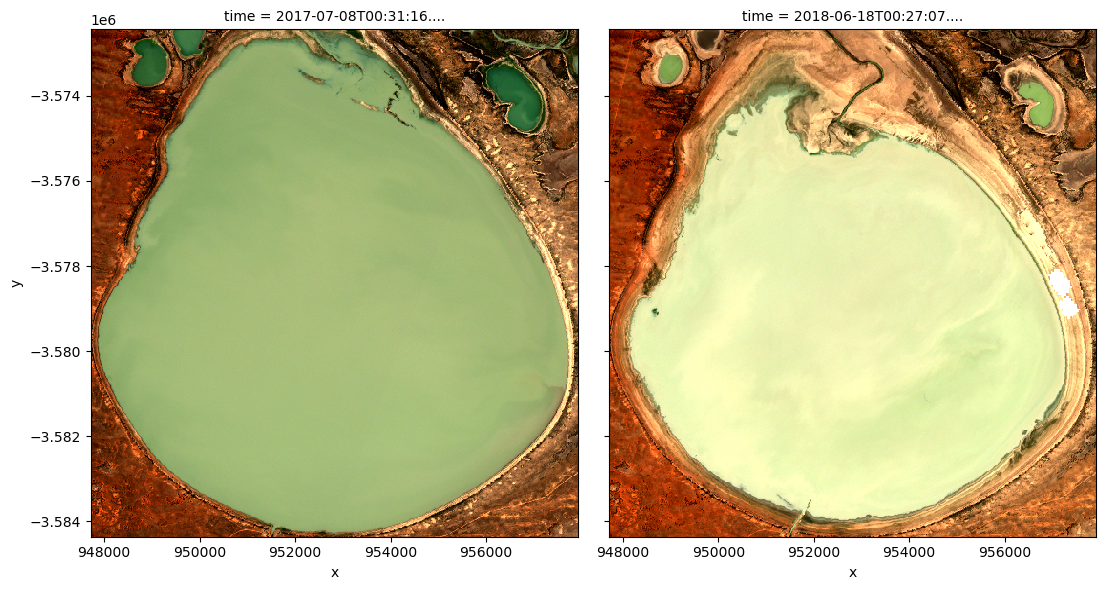

In [7]:
# Set the timesteps to visualise
initial_timestep = 1
final_timestep = 43

# Generate RGB plots at each timestep
rgb(ds_s2, index=[initial_timestep, final_timestep])

## Compute band indices
This study measures the presence of water through the modified normalised difference water index (MNDWI) and clorophyll-*a* through the normalised difference clorophyll index (NDCI).

MNDWI is calculated from the green and shortwave infrared (SWIR) bands to identify water.
The formula is

$$
\begin{aligned}
\text{MNDWI} = \frac{\text{Green} - \text{SWIR}}{\text{Green} + \text{SWIR}}.
\end{aligned}
$$

When interpreting this index, values greater than 0 indicate water.

NDCI is calculated from the red edge 1 and red bands to identify water.
The formula is

$$
\begin{aligned}
\text{NDCI} = \frac{\text{Red edge 1} - \text{Red}}{\text{Red edge 1} + \text{Red}}.
\end{aligned}
$$

When interpreting this index, high values indicate the presence of clorophyll-*a*.

In [8]:
# Calculate MNDWI and add it to the loaded data set
ds_s2 = calculate_indices(ds_s2, index='MNDWI', collection='ga_s2_3')

# Calculate NDCI and add it to the loaded data set
ds_s2 = calculate_indices(ds_s2, index='NDCI', collection='ga_s2_3')

The MNDWI and NDCI values should now appear as data variables, along with the loaded measurements, in the `ds_s2` data set.
Check this by printing the data set below:

In [9]:
ds_s2

<xarray.Dataset>
Dimensions:           (time: 84, y: 596, x: 510)
Coordinates:
  * time              (time) datetime64[ns] 2017-06-03T00:31:18.395000 ... 20...
  * y                 (y) float64 -3.572e+06 -3.572e+06 ... -3.584e+06
  * x                 (x) float64 9.477e+05 9.478e+05 ... 9.579e+05 9.579e+05
    spatial_ref       int32 3577
Data variables:
    nbart_red_edge_1  (time, y, x) float32 1.614e+03 1.831e+03 ... 1.191e+03
    nbart_red         (time, y, x) float32 1.296e+03 1.572e+03 ... 1.122e+03
    nbart_green       (time, y, x) float32 699.0 823.0 929.0 ... 951.0 932.0
    nbart_blue        (time, y, x) float32 418.0 449.0 526.0 ... 773.0 745.0
    nbart_nir_1       (time, y, x) float32 2.279e+03 2.526e+03 ... 1.448e+03
    nbart_swir_2      (time, y, x) float32 3.085e+03 3.454e+03 ... 1.667e+03
    MNDWI             (time, y, x) float32 -0.6305 -0.6152 ... -0.2927 -0.2828
    NDCI              (time, y, x) float32 0.1093 0.07611 ... 0.06025 0.02983
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Build summary plot
To get an understanding of how the waterbody has changed over time, the following section builds a plot that uses the MNDWI to measure the rough area of the waterbody, along with the NDCI to track how the concentration of clorophyll-*a* is changing over time.
This could be used to quickly assess the status of a given waterbody.

### Set up constants
The number of pixels classified as water (MNDWI > 0) can be used as a proxy for the area of the waterbody if the pixel area is known. 
Run the following cell to generate the necessary constants for performing this conversion.

In [10]:
# Constants for calculating waterbody area
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres

area_per_pixel = pixel_length**2 / m_per_km**2

### Compute the total water area
The next cell starts by filtering the data set to only keep the pixels that are classified as water. 
It then calculates the water area by counting all of the MNDWI pixels in the filtered data set, calculating a rolling median (this helps smooth the results to account for variation from cloud-masking), then multiplies this median count by the area-per-pixel.

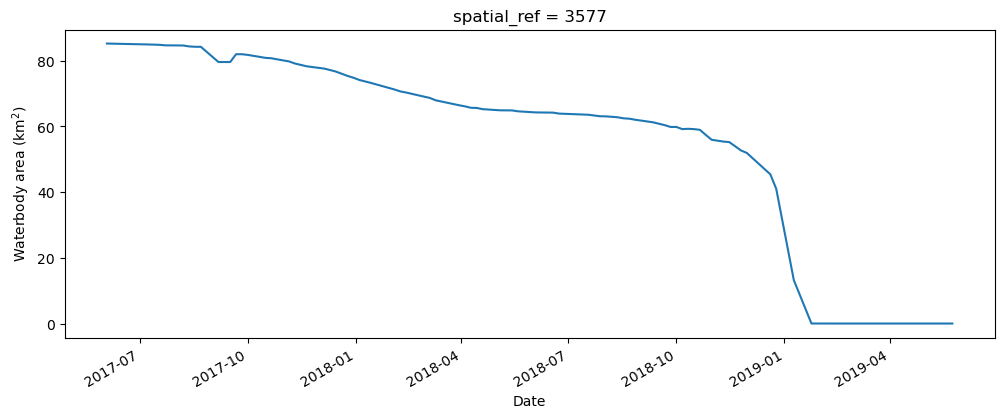

In [11]:
# Filter the data to contain only pixels classified as water
ds_s2_waterarea = ds_s2.where(ds_s2.MNDWI > 0.0)

# Calculate the total water area (in km^2)
waterarea = (
    ds_s2_waterarea.MNDWI.count(dim=["x", "y"])
    .rolling(time=3, center=True, min_periods=1)
    .median(skipna=True)
    * area_per_pixel
)

# Plot the resulting water area through time
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
waterarea.plot()
axes.set_xlabel("Date")
axes.set_ylabel("Waterbody area (km$^2$)")
plt.show()

### Compute the average NDCI
The next cell computes the average NDCI for each time step using the filtered data set.
This means that we're only tracking the NDCI in waterbody areas, and not on any land.
To make the summary plot, we calculate NDCI across all pixels; this allows us to track overall changes in NDCI, but doesn't tell us where the increase occured within the waterbody (this is covered in the next section).

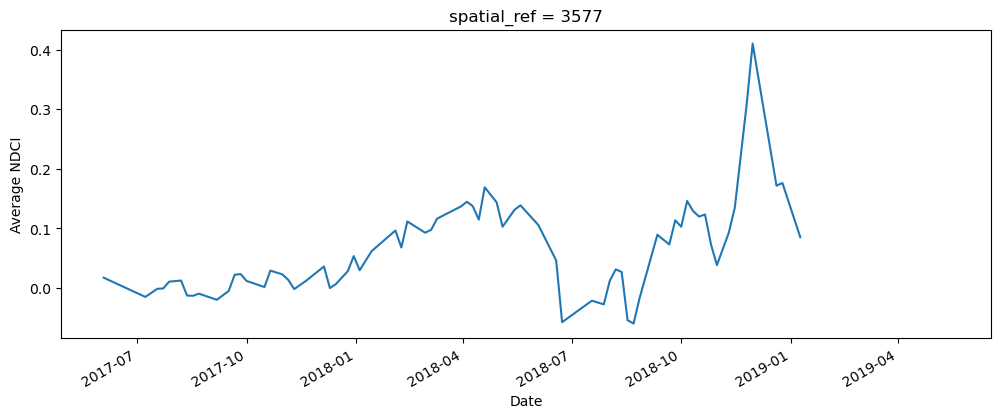

In [12]:
# Calculate the average NDCI
average_ndci = ds_s2_waterarea.NDCI.mean(dim=["x", "y"], skipna=True)

# Plot average NDCI through time
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
average_ndci.plot()
axes.set_xlabel("Date")
axes.set_ylabel("Average NDCI")
plt.show()

### Combine the data to build the summary plot
The cell below combines the total water area and average NDCI time series we generated above into a single summary plot. 
Notice that Python can be used to build highly-customised plots.
If you're interested, take some time to understand how the plot is built.
Otherwise, run the cell to build the plot.

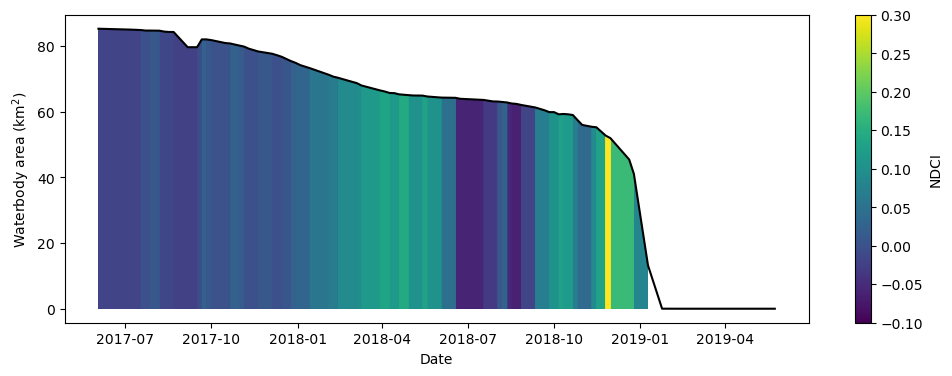

In [13]:
# Set up the figure
fig, axes = plt.subplots(1, 1, figsize=(12, 4))

# Set the colour map to use and the normalisation. NDCI is plotted on a scale
# of -0.1 to 0.3, so the colour map is normalised to these values
min_ndci_scale = -0.1
max_ndci_scale = 0.3
cmap = plt.get_cmap("viridis")
normal = plt.Normalize(vmin=min_ndci_scale, vmax=max_ndci_scale)

# Store the dates from the data set as numbers for ease of plotting
dates = matplotlib.dates.date2num(ds_s2_waterarea.time.values)

# Add the basic plot to the figure
# This is just a line showing the area of the waterbody over time
axes.plot_date(x=dates, y=waterarea, color="black", linestyle="-", marker="")

# Fill in the plot by looping over the possible threshold values and filling
# the areas that are greater than the threshold
color_vals = np.linspace(0, 1, 100)
threshold_vals = np.linspace(min_ndci_scale, max_ndci_scale, 100)
for ii, thresh in enumerate(threshold_vals):
    im = axes.fill_between(dates,
                           0,
                           waterarea,
                           where=(average_ndci >= thresh),
                           norm=normal,
                           facecolor=cmap(color_vals[ii]),
                           alpha=1)

# Add the colour bar to the plot
cax, _ = matplotlib.colorbar.make_axes(axes)
cb2 = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normal)
cb2.set_label("NDCI")

# Add titles and labels to the plot
axes.set_xlabel("Date")
axes.set_ylabel("Waterbody area (km$^2$)")
plt.show()

What does the plot reveal about the waterbody? 
Are there periods that show high NDCI values?

## Compare spatial NDCI at two different dates
While the summary plot is useful at a glance it can be interesting to see the full spatial picture at times where the NDCI is low vs. high.
The code below defines two useful functions: `closest_date` will find the date in a list of dates closest to any given date; `date_index` will return the position of a particular date in a list of dates. 
These functions are useful for selecting images to compare. 

In [14]:
def closest_date(list_of_dates, desired_date):
    return min(list_of_dates,
               key=lambda x: abs(x - np.datetime64(desired_date)))

def date_index(list_of_dates, known_date):
    return (np.where(list_of_dates == known_date)[0][0])

Run the cell below to set two dates to compare.
Feel free to change the dates to look at the NDCI of the waterbody at different times.

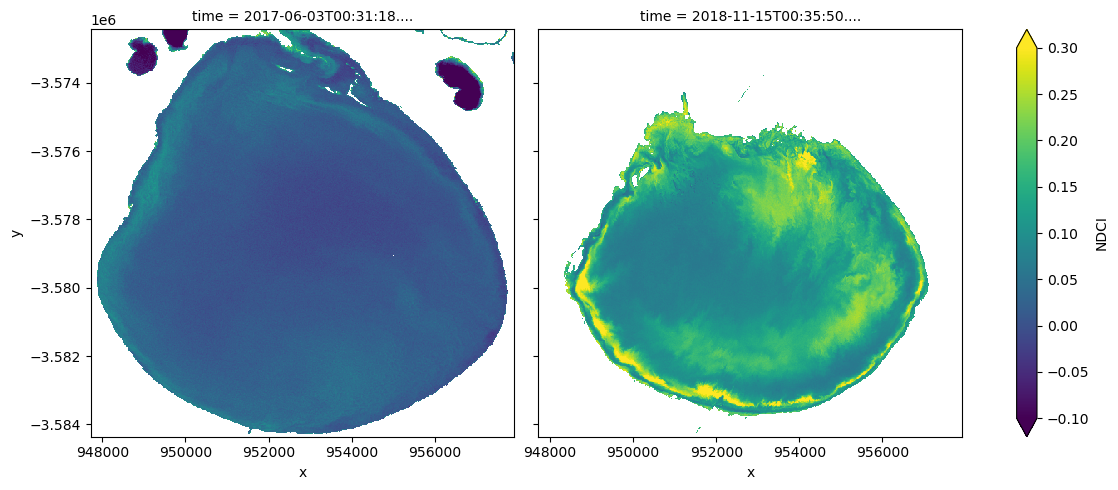

In [15]:
# Set the dates to view
date_1 = "2017-02-15"
date_2 = "2018-11-15"

# Compute the closest date available from the data set
closest_date_1 = closest_date(ds_s2.time.values, date_1)
closest_date_2 = closest_date(ds_s2.time.values, date_2)

# Make an xarray containing the closest dates, which is used to select
# the dates from the data set
time_xr = xr.DataArray([closest_date_1, closest_date_2], dims=["time"])

# Plot the NDCI values for pixels classified as water for the two dates.
ds_s2_waterarea.NDCI.sel(time=time_xr).plot.imshow(col="time",
                                                   cmap=cmap,
                                                   vmin=min_ndci_scale,
                                                   vmax=max_ndci_scale,
                                                   col_wrap=2,
                                                   robust=True,
                                                   figsize=(12, 5))
plt.show()

Run the cell below to see the true-colour images for the same dates

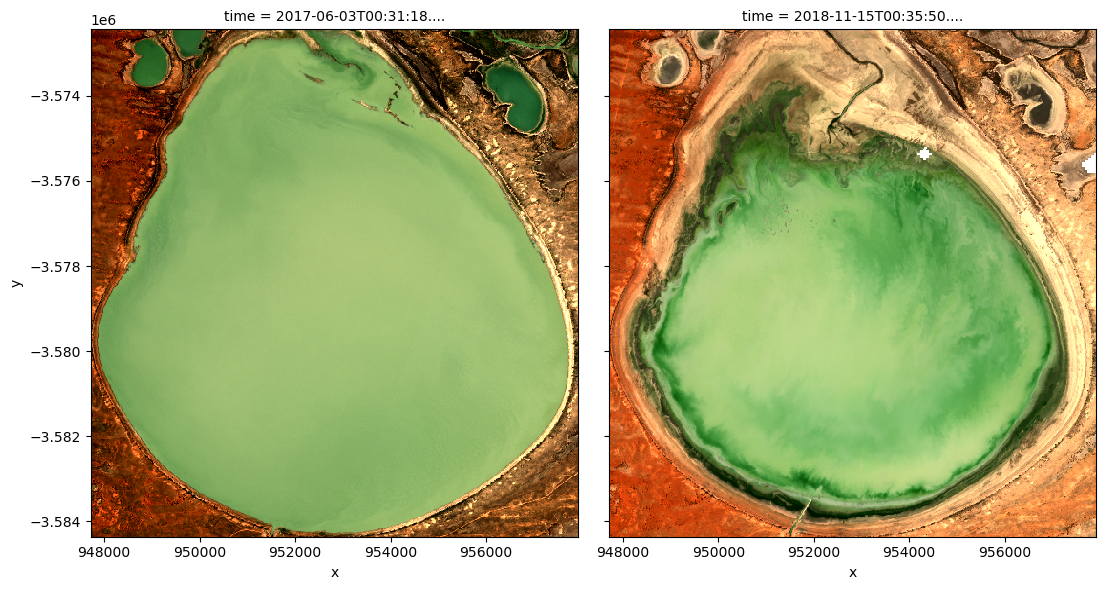

In [16]:
# Compute the index of the closest dates
closest_date_1_idx = date_index(ds_s2.time.values, closest_date_1)
closest_date_2_idx = date_index(ds_s2.time.values, closest_date_2)

# Make the true colour plots for the closest dates
rgb(ds_s2, index=[closest_date_1_idx, closest_date_2_idx])

## Drawing conclusions
Here are some questions to think about:

* How well do increased NDCI values match with what you see in the true-colour images?
* When would it be more helpful to use the summary plot vs. the time comparison plot and vice-versa?
* What does the water look like in the true-colour image when the NDCI is low-to-medium vs. high?
* What other information might you seek if you detected an abnormally high NDCI value?

## Next steps

When you are done, return to the "Analysis parameters" section, modify some values (e.g. `latitude`, `longitude` or `time`) and rerun the analysis.
You can use the interactive map in the "View the selected location" section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for.
You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.

If you're going to change the location, you'll need to make sure Sentinel-2 data is available for the new location, which you can check at the [DEA Explorer](https://explorer.sandbox.dea.ga.gov.au/ga_s2am_ard_3).
Use the drop-down menu to check both Sentinel-2a (`ga_s2am_ard_3`) and Sentinel-2b (`ga_s2bm_ard_3`). 

If you want to look at another of the Menindee Lakes, try the following coordinates over the same time period as the original example:

```
latitude = (-32.415, -32.273)
longitude = (142.228, 142.409)
```

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** February 2023

**Compatible datacube version:** 

In [17]:
print(datacube.__version__)

1.8.11


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)